In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pulp
from ortools.sat.python import cp_model
import time

from utility import *
from reconstruit import *
from tools_base import *
from tools import *

### Goal
The goal of this notebook is to implement an algorithm to find a longest path that visits each node at most once. We use the open-source software Google's OR-Tools \url{https://developers.google.com}   The objective function (Hamiltonian) to minimize is the following:
$$ H(x)=\delta\sum_{i,j=1}^n (1-\omega_{i,j})x_{i,j}+ \alpha\sum_{i=1}^n\left(1-\sum_{j=1}^n x_{i,j}\right)^2+
\beta\sum_{j=1}^n\left(1-\sum_{i=1}^n x_{i,j}\right)^2+ \gamma \sum_{i=1}^n\left( \sum_{j=1}^n x_{i,j}-\sum_{k=1}^n x_{k,i}\right)^2 $$
$n$ is number of nodes and $\alpha, \beta, \gamma, \delta$ are penalised coefficients.

 $x$ is a decision variable and is defined as follows 

$$ x=(x_{i,j})_{1\le i,j\le n},\quad x_{i,j}\in \{0,1\} $$

We develop the Hamiltonian

$$  H(x)=\sum_{i,j=1}^n\left(\delta(1-\omega_{i,j})-\alpha-\beta+2\gamma \right)x_{i,j} +2\sum_{i=1}^n\sum_{j<k} (\alpha+\gamma)x_{i,j}x_{ik} +2\sum_{j=1}^n\sum_{i<k} (\beta+\gamma)x_{i,j}x_{k,j} -2\gamma\sum_{i,j,k=1}^n x_{k,j}x_{i,k} $$

Then we linearize the quadratic terms. In fact, OR-Tools allows linear objective function 
$$ y^{row}_{i,j,k}=x_{i,j}x_{i,k} \;\;\text{   avec   } \;\; y^{row}_{i,j,k}\le x_{i,j},\; y^{row}_{i,j,k}\le x_{i,k},\; y^{row}_{i,j,k}\ge x_{i,j}+ x_{i,k}-1 $$

$$  y^{cell}_{j,i,k}= x_{i,j}x_{k,j}\;\; \text{   avec   }\;\; y^{cell}_{j,i,k}\le x_{i,j},\; y^{cell}_{j,i,k}\le x_{k,j},\; y^{cell}_{j,i,k}\ge x_{i,j}+ x_{k,j}-1 $$

$$ z_{k,j,i}=x_{k,j}x_{i,k} \;\;\text{   avec   }\;\; z_{k,j,i}\le x_{i,k},\; z_{k,j,i}\le x_{k,j},\; z_{k,j,i}\ge x_{i,k}+ x_{k,j}-1$$


We first find the biggest of a compacted de Bruijn graph for a bacterial genome, 

In [3]:
# Prepare and use the biggest component
verbose=False
filename="graph_genome"
path="spneumoniae_k_121.unitigs.fa"
G = generate_de_bruijn_graph_from_fa(path,verbose)
save_graph_to_html(G,filename+"_de-Bruijn")
remove_isolated_nodes(G,verbose)
DG = convert_de_bruijn_to_digraph(G,verbose)

SG = find_biggest_component(DG)

In [5]:
# Adjacent matrice of the matrice SG
adj_matrix_SG = nx.adjacency_matrix(SG, nodelist=SG.nodes()).todense()


# Creation of registre thats maps nodes of SG onto liste [1,2,3,...]
registre_nodes_SG={}
num=0
for node in SG.nodes():
    registre_nodes_SG[node]=num
    num+=1

# Creation of registre thats maps edges of SG onto liste [1,2,3,...]
registre_edges_SG={}
num=0
for edge in SG.edges():
    registre_edges_SG[edge]=num
    num+=1

# Nodes of SG
nodes_SG=list(SG.nodes())

# Edges of SG
edges_SG=list(SG.edges())


In [6]:
# Creation of registre that contains the predecessors of nodes
# Creation of another registre that contains the successors of nodes
registre_predecessors_SG={}
registre_successors_SG={}
for node in list( SG.nodes() ):
    registre_predecessors_SG[node]=list( SG.predecessors(node) )
    registre_successors_SG[node]=list( SG.successors(node) )
    

In [ ]:
# Verification of adjacent matrix
matr_adj_copy= adj_matrix_SG.copy()
for edge in list(SG.edges()):
    k1=registre_nodes_SG[edge[0]]
    k2= registre_nodes_SG[edge[1]]
    matr_adj_copy[k1][k2]=0
for i in range(len(matr_adj_copy)):
    for j in range(len(matr_adj_copy)):
        if matr_adj_copy[i][j]!= 0:
            print(f"La matrice adjacente est incorrecte i,j={i},{j}")

In [8]:
len(SG.nodes())

240

Next, we are going to find the output path which minimizes the Hamiltonian defined above. We fix $\alpha=\beta=20$ and $\delta=10$. The parameter $\gamma$ is varied over the set $\{2,30, 35, 40, 45, 25, 20, 27, 48, 42, 38, 15, 12, 100, 200, 300\}$ and adjusted until a valid path is obtained.

In [ ]:
# ---------------------
# Données du problème
# ---------------------
#n=6
n = len(edges_SG)  # taille du problème
no = len(nodes_SG)
# Paramètres
list_gamma=[2,30,35,40,45,25,20,27,48,42,38,15,12,100,200,300]
alpha = 20   # pondération des pénalités de ligne
beta = 20   # pondération des pénalités de colonne

delta=10
model = cp_model.CpModel()
for gamma in list_gamma:

    # ---------------------
    # Variables
    # ---------------------
    x = {}
    for i in range(n):
            x[i] = model.NewIntVar(0, 1, f"x_{i}")


    # ---------------------
    # Fonction objectif
    # ---------------------
    objective_terms = []


    # linear temrs

    for node in nodes_SG:
        
        sucessor=registre_successors_SG[node]
        for node_successor in sucessor:
            i=registre_edges_SG[(node, node_successor )]
            objective_terms.append(  (gamma-alpha)* x[i])

        predecessor= registre_predecessors_SG[node]
        for node_predecessor in  predecessor:
            j= registre_edges_SG[(node_predecessor, node )]
            objective_terms.append(  (gamma-beta)* x[j])

    # Quadratic terms
    for node in nodes_SG:
        
        sucessor=registre_successors_SG[node]
        # row penalities: 2(alpha+gamma)*x[i,j]*x[i,k] for j<k
        for node_successor_j in sucessor:
            for node_successor_k in sucessor:
                if node_successor_j != node_successor_k:
                    k= registre_edges_SG[(node, node_successor_k )]
                    j=registre_edges_SG[(node, node_successor_j )]
                    Y_kj = model.NewIntVar(0, 1, f"Y_{k}_{j}")
                    model.AddMultiplicationEquality(Y_kj, [x[k], x[j]])
                    objective_terms.append(  (alpha+gamma) * Y_kj)


        predecessor= registre_predecessors_SG[node]
        # Column penalties : 2*(beta+gamma)* x[i,j]*x[k,j] for i<k
        for node_predecessor_i in predecessor:
            for node_predecessor_k in predecessor:
                if node_predecessor_i != node_predecessor_k:
                    i=registre_edges_SG[(node_predecessor_i,node)]
                    k=registre_edges_SG[(node_predecessor_k,node)]
                    y_ik = model.NewIntVar(0, 1, f"y_{i}_{k}")
                    model.AddMultiplicationEquality(y_ik, [x[i], x[k]])
                    objective_terms.append(  (beta+gamma) * y_ik)

        # Adjusted flow penalty : -2*gamma* x[k,j]*x[i,k]
        for node_successor_k in sucessor:
            for node_predecessor_j in predecessor:
                k=registre_edges_SG[(node, node_successor_k )]
                j=registre_edges_SG[(node_predecessor_j,node)]
                z_jk = model.NewIntVar(0, 1, f"z_{j}_{k}")
                model.AddMultiplicationEquality(z_jk, [x[j], x[k]])
                objective_terms.append( -2* (gamma) * z_jk)
                

    model.Minimize(sum(objective_terms))

    # ---------------------
    # Resolution
    # ---------------------
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 10
    status = solver.Solve(model)

    # Check
    GLP=nx.DiGraph()
    for i in range(n):
        if solver.Value(x[i])==1:
                GLP.add_node((edges_SG[i])[0])
                GLP.add_node((edges_SG[i])[1])
                GLP.add_edge( (edges_SG[i])[0], (edges_SG[i])[1] )  

    
    
    if check_path(  GLP ): # if True
        print(True)
        break # we out the boucle for gama in list_gamma

        # ---------------------
        # Résultats
        # ---------------------
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("\nSolution finded :")
        #for i in range(n):
            #print([solver.Value(x[i,j]) for j in range(n)])
        print("Value of ojective :", solver.ObjectiveValue())
    else:
        print(" Aucune solution trouvée.")


Solution finded :
Value of ojective : -5176.0

Solution finded :
Value of ojective : -4880.0

Solution finded :
Value of ojective : -4840.0

Solution finded :
Value of ojective : -4800.0

Solution finded :
Value of ojective : -4760.0

Solution finded :
Value of ojective : -4920.0

Solution finded :
Value of ojective : -4960.0

Solution finded :
Value of ojective : -4904.0

Solution finded :
Value of ojective : -4736.0

Solution finded :
Value of ojective : -4784.0

Solution finded :
Value of ojective : -4816.0

Solution finded :
Value of ojective : -5020.0

Solution finded :
Value of ojective : -5056.0

Solution finded :
Value of ojective : -4320.0
True


In [22]:
# Longest path
GLP=nx.DiGraph()
for i in range(n):
    if solver.Value(x[i])==1:
          GLP.add_node((edges_SG[i])[0])
          GLP.add_node((edges_SG[i])[1])
          GLP.add_edge( (edges_SG[i])[0], (edges_SG[i])[1] )  

In [ ]:
# Print the finded path 1
net = Network(notebook=False, directed=True)
# Ajouter SG en bleu
for node in SG.nodes():
    if node in GLP.nodes():
        net.add_node(node, color="#0ADC70")
    else :
        net.add_node(node, color="#84B8D9")
for edge in SG.edges():
    if edge in GLP.edges():
        net.add_edge(edge[0], edge[1], color="#5A9C56")   
    else :
        net.add_edge(edge[0], edge[1], color="#84B8D9")
 # Optional: show physics options in the browser
net.show_buttons(filter_=['physics'])
net.write_html('graph_genom_longest_path.html')

In [ ]:
# Print the finded path 2
net = Network(notebook=False, directed=True)
# Ajouter SG en bleu
for node in SG.nodes():
    net.add_node(node, color="lightblue")
for edge in SG.edges():
    net.add_edge(edge[0], edge[1], color="blue")

# Ajouter GLP en rouge
for node in GLP.nodes():
    net.add_node(node, color="pink")
for edge in GLP.edges():
    net.add_edge(edge[0], edge[1], color="red")   

net.write_html('graph_genom_longest_path_new.html')

240

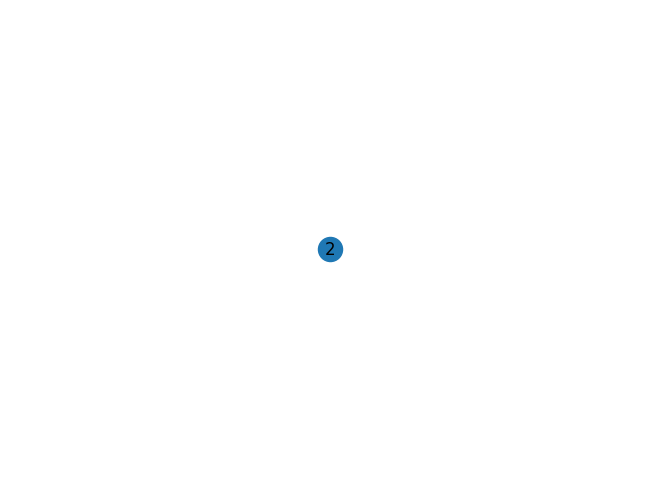